Лабораторная работа №2

In [3]:
import pandas as pd 
import numpy as np
import scipy
from scipy import stats
import re
import math
import datetime
import calendar
from matplotlib import pyplot as plt

Берём данные о погоде в Гусь-Хрустальном с сайта Rp5.ru за 2019 год.

Сразу меняем название первого столбца и оставляем всего несколько показателей:

DT - Дата/время

T - Температура

P - Атмосферное давление, приведённое к среднему уровню

Конвертируем строковые даты в формат datetime64 и сортируем таблицу по дате.

In [4]:
df=pd.read_csv("gus3.csv", sep=";")
df.rename(columns={'Местное время в Гусь-Хрустальном':'DT'}, inplace=True)
df = df.shift(1,axis=1).reset_index()
df['DT'] = df['index']
df.drop('index', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df = df[['DT', 'T', 'P']]
df['DT'] = pd.to_datetime(df['DT'])
df = df.sort_values(by='DT')
columns = list(df)
columns.remove('DT')
for a in columns:
    df[a].fillna(df[a].groupby([df.DT.dt.year, df.DT.dt.month]).transform('mean'), inplace=True)
df

,DT,T,P
2918,2019-01-01 00:00:00,-8.7,770.8
2917,2019-01-01 03:00:00,-11.9,770.7
2916,2019-01-01 06:00:00,-9.3,768.7
2915,2019-01-01 09:00:00,-9.1,767.9
2914,2019-01-01 12:00:00,-8.2,765.7
...,...,...,...
4,2019-12-31 09:00:00,0.4,745.5
3,2019-12-31 12:00:00,0.7,745.4
2,2019-12-31 15:00:00,0.7,745.1
1,2019-12-31 18:00:00,0.5,744.7


Линейная регрессия:

Общий вид Регрессионной модели:

$y = f(x,b) + \epsilon, E(\epsilon)=0$

Общий вид линейной регрессии:

$f(x,b) = b_0 + b_1x_1 + b_2x_2 + ... + b_kx_k$

где $b_{j}$ — параметры (коэффициенты) регрессии, $x_{j}$ — регрессоры (факторы модели), $k$ — количество факторов модели

У нас частный случай - $x$ это один фактор, тмпература. Поэтому формула изменяется до простейшей:

$y_t = a + bx_t + \epsilon_t$

В данной лабораторной работе будет рачитываться зависимость *температуры* от *давления*

Начнём с ручного расчёта. Сортируем таблицу по месяцам, дням и средним значениям температуры и давления.

In [5]:
test = df.groupby([df.DT.dt.month, df.DT.dt.day])
a, b = test.T.mean(), test.P.mean()
test_df = a.to_frame().join(b.to_frame())
test_df

T         P
DT DT                  
1  1  -8.7875  766.2875
   2  -5.5875  765.3000
   3  -0.8625  739.6000
   4   4.8000  758.9500
   5   7.4125  761.8750
...       ...       ...
12 27 -5.0000  759.0625
   28 -4.5750  765.2250
   29 -5.0375  773.0375
   30 -4.0125  764.7125
   31 -0.2000  746.0500

[365 rows x 2 columns]

Находим среднее значение температуры, давления и  коэффициенты a и b с помощью метода наименьших квадратов:

$ b = \frac { \sum_{i=1}^n (x_i - \bar{x})(y_i - \bar{y}) } {\sum_{i=1}^n (x_i - \bar{x})^2}$

$a = \bar{y} - b\bar{x} $

In [6]:
test_df = df[df.DT.dt.month == 10]
est_df = test_df.sort_values(by='T')
X = np.array(test_df['T'])
Y = np.array(test_df['P'])
m = len(X)
mean_x = X.mean()
mean_y = Y.mean()
print("Среднее значение температуры: {}, \nСреднее значение давления: {}\n".format(mean_y, mean_x))
chis = sum((X - mean_x) * (Y - mean_y))
znam = sum((X - mean_x) ** 2)
b = chis / znam
a = mean_y - (b * mean_x)
print ("b = {}; a = {};".format(b, a))

Среднее значение температуры: 761.6274193548386, 
Среднее значение давления: 8.258064516129032

b = -0.12021932485598572; a = 762.6201982955848;


Составим модель линейной регрессии, на которйо наглядно будет видно, насколько она совпадает с реальностью 

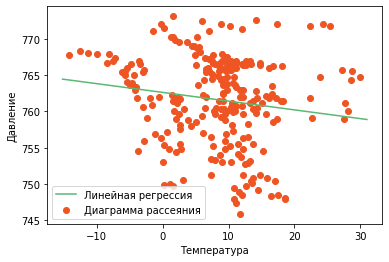

In [7]:
max_x = np.max(X) + 1
min_x = np.min(X) - 1

x = np.linspace(min_x, max_x, 1000)
y = a + b * x

plt.plot(x, y, color='#58b970', label='Линейная регрессия')
plt.scatter(X, Y, color='#ef5423', label='Диаграмма рассеяния')

plt.xlabel('Температура')
plt.ylabel('Давление')
plt.legend()
plt.show()

In [9]:
rmse = 0
for i in range(m):
    y_pred = a + b * X[i]
    rmse += (Y[i] - y_pred) ** 2
rmse = np.sqrt(rmse/m)
print('Среднеквадратичное отклонение вручную:', rmse)
ss_t = 0
ss_r = 0
for i in range(m):
    y_pred = a + b * X[i]
    ss_t += (Y[i] - mean_y) ** 2
    ss_r += (Y[i] - y_pred) ** 2
r2 = 1 - (ss_r/ss_t)
print("R2 ручная:", r2)

Среднеквадратичное отклонение вручную: 6.054943960858715
R2 ручная: 0.023216907628074046


Сделаем всё то же самое, но уже "автоматически"

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = X.reshape((-1, 1))
reg = LinearRegression()
reg = reg.fit(X, Y)
Y_pred = reg.predict(X)

rmse = np.sqrt(mean_squared_error(Y, Y_pred))
r2 = reg.score(X, Y)

print("Среднеквадратичное отклонение автоматическое:", rmse)
print("R2 автоматическое:", r2)

Среднеквадратичное отклонение автоматическое: 6.054943960858715
R2 автоматическое: 0.023216907628074712


Составим ещё одну модель линейной регрессии, и проверим сходство.

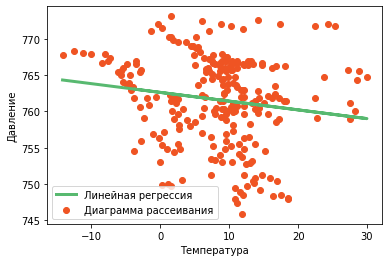

In [12]:
plt.scatter(X, Y, color='#ef5423', label='Диаграмма рассеивания')
plt.plot(X, Y_pred, color='#58b970', label='Линейная регрессия', linewidth=3)

plt.xlabel('Температура')
plt.ylabel('Давление')
plt.legend()
plt.show()

Авторегрессия:

Для построения данной модели будем использовать ARIMA

In [18]:
import re
import calendar
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, pacf, acf
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline

Посмотроим временные графики и корреляцию

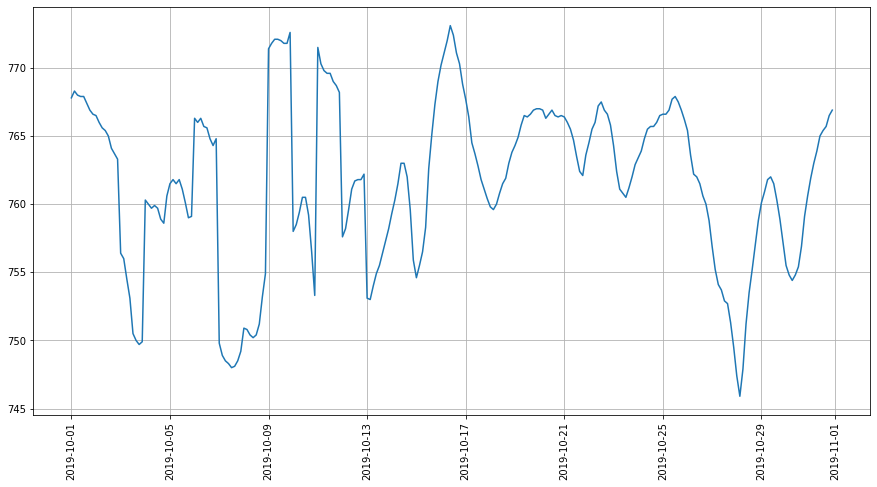

In [19]:
new_df2 =  df[df.DT.dt.month == 10]
new_df2 = new_df2
column = 'P'
plt.figure(figsize=[15,7.5])
plt.plot(new_df2['DT'],new_df2[column])
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

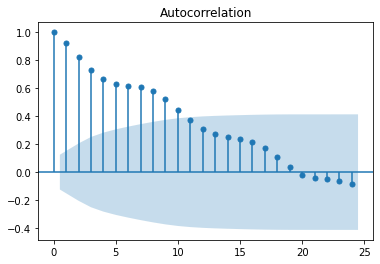

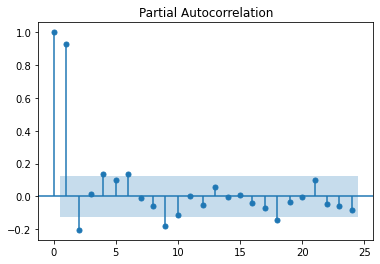

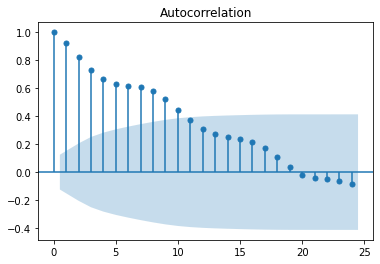

In [20]:
plot_pacf(new_df2['T'])
plot_acf(new_df2['T'])

In [21]:
res=adfuller(new_df2[column])
print('ADF =',res[0])
print('pvalue =',res[1])

ADF = -3.6739779164443696
pvalue = 0.004494428356859194


$pvalue < 0.05$ Что хорошо - ряд Стационарен и с ним можно продолжать работать

Однако для улучшения данны прологарифмируем их и сделает один вычет

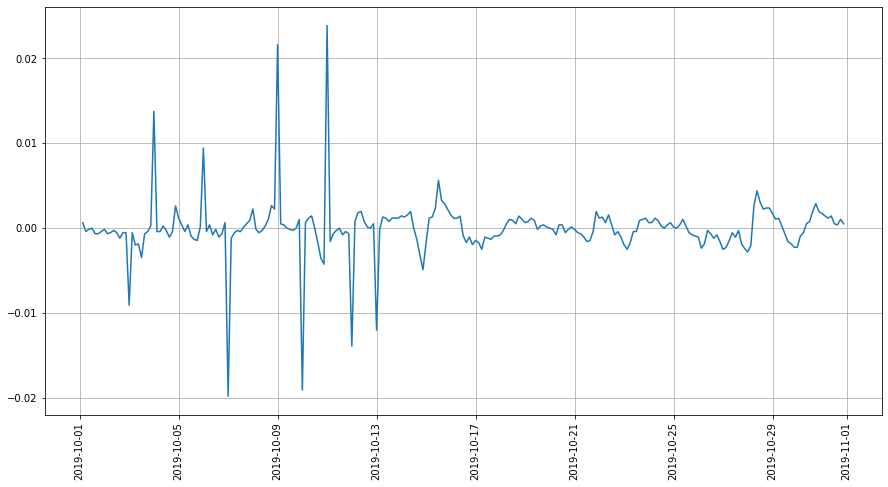

In [23]:
new_df2[column]=np.log(new_df2[column])
new_df2[column]=new_df2[column].diff()
new_df2=new_df2.drop(new_df2.index[0])
plt.figure(figsize=[15,7.5])
plt.plot(new_df2['DT'],new_df2[column])
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [24]:
res=adfuller(new_df2[column])
print('ADF=',res[0])
print('pvalue=',res[1])

ADF= -6.0195806479611935
pvalue= 1.5049266474417032e-07


$pvalue < 0.05$ И стал ещё меньше. Сами данные приняли более приемлимый видл для исследования

In [48]:
from tqdm import tqdm_notebook
def optimizeARIMA(order_list,exog):
    results=[]
    for order in tqdm_notebook(order_list):
        try:
            model=SARIMAX(exog,order=order).fit(disp=-1)
        except:
            continue
        aic=model.aic
        results.append((order,model.aic))
    result_df=pd.DataFrame(results)
    result_df.columns=['p,d,q','aic']
    result_df=result_df.sort_values(by='aic',ascending=True).reset_index(drop=True)
    return result_df

Используем диапазон от 0 до 8, при d = 1

In [49]:
from itertools import product
ps=range(0,8,1)
qs=range(0,8,1)
d=1
parametrs=product(ps,qs)
plist=list(parametrs)
plist
olist=[]
for p in plist:
    p=list(p)
    p.insert(1,1)
    p=tuple(p)
    olist.append(p)
olist
result_df=optimizeARIMA(olist, exog = new_df2[column])

**aic** - информационный критерий модели

In [50]:
result_df

,"p,d,q",aic
0,"(5, 1, 7)",-2116.022937
1,"(7, 1, 6)",-2113.864147
2,"(7, 1, 7)",-2109.075379
3,"(5, 1, 6)",-2108.668645
4,"(2, 1, 7)",-2100.391802
...,...,...
59,"(3, 1, 0)",-2032.046849
60,"(2, 1, 0)",-2022.287781
61,"(6, 1, 1)",-2018.125782
62,"(1, 1, 0)",-2000.170038


In [51]:
new_df2 =  df[df.DT.dt.month == 3]
new_df2 = new_df2
train = new_df2[column][:len(new_df2[column]) - 100]
test = new_df2[column][len(new_df2[column]) - 100:]
size = len(new_df2[column]) - 100
best_model=SARIMAX(train, order=(7,1,5)).fit()
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      P   No. Observations:                  148
Model:               SARIMAX(7, 1, 5)   Log Likelihood                -357.785
Date:                Thu, 21 Jan 2021   AIC                            741.570
Time:                        07:08:07   BIC                            780.445
Sample:                             0   HQIC                           757.365
                                - 148                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0611      0.602     -1.762      0.078      -2.242       0.119
ar.L2         -0.0940      0.561     -0.168      0.867      -1.194       1.006
ar.L3          0.7537      0.272      2.768      0.0

Предсказание ARIMA

In [53]:
predictions = best_model.predict(start = size, end=size + 99)
forecast_1= best_model.forecast(steps=1)
act= pd.DataFrame(test)
print(act)
predictions=pd.DataFrame(predictions)
print(predictions)

          P
2298  766.0
2297  765.7
2296  766.0
2295  766.9
2294  767.0
...     ...
2203  757.2
2202  755.7
2201  754.6
2200  754.6
2199  754.4

[100 rows x 1 columns]
     predicted_mean
148      765.094817
149      763.684617
150      762.682697
151      761.790774
152      761.105802
..              ...
243      760.388739
244      760.387792
245      760.389848
246      760.388054
247      760.388247

[100 rows x 1 columns]


,Pred,Actual
2298,765.094817,766.0
2297,763.684617,765.7
2296,762.682697,766.0
2295,761.790774,766.9
2294,761.105802,767.0


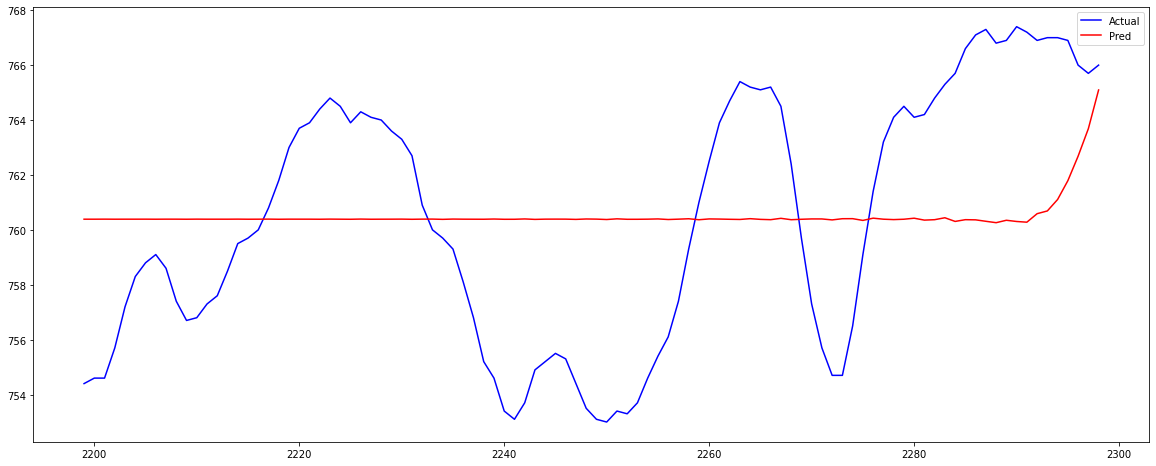

In [54]:
predictions.index=test.index
predictions['Actual'] = act[column]
predictions.rename(columns={'predicted_mean':'Pred'}, inplace=True)
predictions['Actual'].plot(figsize=(20,8), legend=True, color='blue')
predictions['Pred'].plot(legend=True, color='red', figsize=(20,8))
predictions.head()

In [56]:
start_index = 3
end_index = 7
forecast = best_model.predict(start=start_index, end=end_index)
# invert the differenced forecast to something usable
print("Предсказанное:")
for yhat in forecast:
    print(yhat * 100)
print("Изначальное:")
for x in new_df2['P'][3:8]:
    print(x * 100)

Предсказанное:
76092.27077918767
76196.35586014738
76301.41436653712
76298.79540510327
76331.65587576272
Изначальное:
76190.0
76300.0
76310.0
76350.0
76350.0


In [57]:
new_df2['P']

2902    760.0
2901    760.6
2900    760.9
2899    761.9
2898    763.0
        ...  
2203    757.2
2202    755.7
2201    754.6
2200    754.6
2199    754.4
Name: P, Length: 248, dtype: float64

In [58]:
new_df2['P'][3:10]

2899    761.9
2898    763.0
2897    763.1
2896    763.5
2895    763.5
2654    768.0
2653    768.1
Name: P, dtype: float64